This notebook aims at showing the performance of sound classification using different approach


In [1]:
# dependence for whole notebook

import numpy as np
import pandas
import os
import glob
import pandas as pd
from sound_classification import classification_service
from sklearn.metrics import confusion_matrix

import random

import sound_classification.confusion_matrix
random.seed = 0

%pylab inline

ImportError: No module named features


# Using MFCC + SVC (actual default approach)


IT corresponds to what we have so far done, it's a default scheme now that has been test with some sucess on an online robot

## Aldebaran sound dataset v1 

sounds presents are : applause, deskbell, doorbell, firealarm, tactac mouse sound, whistle 
it corresponds to the dataset as provided on dropbox [here](https://www.dropbox.com/s/ekldjq8o1wfhcq1/dataset_aldebaran_6sounds.tar.gz?dl=0)

expected accuracy is above 70 % minimum (except for applause that could be a little less)

In [7]:
from tests.test_bell_detection import _get_training_data

dataset_path = _get_training_data()  # dowloading dataset from dropbox
file_regexp = os.path.join(dataset_path, '*.wav')
files = glob.glob(file_regexp)

In [4]:
# computing dataset cross validation 10-fold stratified, and also keeping another data..

In [5]:
# we process file one by one, using the wav so it's the same process as the one on the robot

In [8]:
_class = [os.path.basename(f).split('-')[0] for f in files]
df = pd.DataFrame(zip(_class, files), columns=['classname', 'filename'])

df = df[~df.filename.str.contains('Romeo')]  # we remove file recorded on romeo from the database.. because there are in 44100Hz not 48000

print(df.classname.value_counts())

TacTac         51
Whistle        42
DeskBell       41
FireAlarmFr    32
DoorBell01     23
DoorBell02     22
Applause       16
dtype: int64


On voit qu'on a vraiment peut d'applause par rapport au reste... ça pourrait expliquer une différence de resultats.. a voir dans la suite..

In [9]:
from sklearn.cross_validation import StratifiedKFold
n_folds = 3
stratified_fold = StratifiedKFold(df.classname, n_folds)  # we use only 3 fold.. as we have only 16 values on some data

folds = list(stratified_fold)
#folds[0] # training index
#folds[1] # testing_index

#training_folds = zip(*list(stratified_fold))
#testing_folds = zip(*list(stratified_fold))

In [23]:
reload(classification_service)
def get_expected_predicted_stratified_fold(stratified_fold, df, window_block=None):    
    """ 
    Tool function to report classification accuracy for our classification tools
    """
    predicted=[]
    expected=[]
    filenames = []
    
    fold_num = 0
    for train_set, test_set in stratified_fold:
        train_files = df.iloc[train_set].filename
        sound_classification_obj = classification_service.SoundClassification(train_files.tolist())
        sound_classification_obj.learn()
        labels = sound_classification_obj.clf.classes_
        for index in test_set:
            val = df.iloc[index]
            try:
                prediction = sound_classification_obj.processed_wav(val.filename, window_block=window_block, ignore_fs=True)
                expected.extend([val.classname]*len(prediction))
                predicted.extend(prediction)
                filenames.extend(['_'.join([val.filename, '_fold%s' % fold_num])]*len(prediction))  # we append the num of fold to filename to have easy difference after that.... TODO: use another column
            except classification_service.SoundClassificationException as e: 
                print("Exception %s detected on %s" % (e, val.filename))
        fold_num += 1
    return expected, predicted, labels, filenames   # ca commence a faire beaucoup, pourquoi ne pas renvoyer un dictionnaire, ou un pandas DataFrame: TODO

def print_report(expected, predicted_class, labels):
    # compute confusion matrix
    matrix = confusion_matrix(expected, predicted_class, labels=labels)
    print(matrix)

    # plot confusion matrix
    sound_classification.confusion_matrix.displayConfusionMatrix(matrix, labels=labels)
    
    # print report
    import sklearn
    print(sklearn.metrics.classification_report(expected, predicted_class))
    
#matrix = confusion_matrix(predicted, expected, labels=labels)

In [11]:
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df)
predicted_class = [x.class_predicted for x in predicted]

[[16  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  3]
 [ 0  0 23  0  0  0  0]
 [ 0  0  0 22  0  0  0]
 [ 0  0  0  0 32  0  0]
 [ 0  0  0  0  0 50  1]
 [ 0  0  0  0  0  1 41]]


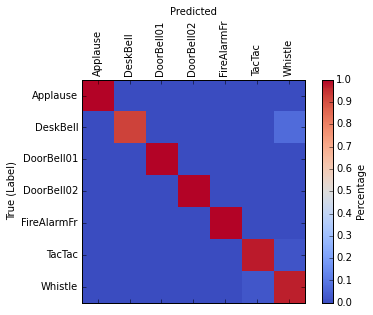

             precision    recall  f1-score   support

   Applause       1.00      1.00      1.00        16
   DeskBell       1.00      0.93      0.96        41
 DoorBell01       1.00      1.00      1.00        23
 DoorBell02       1.00      1.00      1.00        22
FireAlarmFr       1.00      1.00      1.00        32
     TacTac       0.98      0.98      0.98        51
    Whistle       0.91      0.98      0.94        42

avg / total       0.98      0.98      0.98       227



In [12]:
print_report(expected, predicted_class, labels)

## Conclusion:
pour les classes Applause, Doorbell01, Doorbell02, FireAlarm on a une precision de 100% et un rappel de 100% -> le classifier est parfait.

Pour la classe Deskbell on a un rappel de 0.93, la matrice de confusion nous dit que 3 des 41 sons deskbell on en effet été classifié comme des Whistle. (3/41 == 0.07 d'ou le 93% de recall)

Pour la classe Tactac, elle est classifié 2% du temps comme des whistle (un seul fichier comme nous le dit la matrice de confusion). On voit aussi que la précision n'est pas de 100%, en effet des whistle sont classifié comme des tactac
Pour la classe Whistle, on a un recall de 0.98 %, en effet 2% des whistle sont classifié comme des tactac.
On a aussi une precision de 0.91%, ce qui correspond aux deskbell et aux tactac classifié comme des whistle.

Enfin bon ce qu'il faut retenir c'est que ça marche vraiment très très bien, presque trop bien je trouve pour de la cross validation (bon la on utilise tout le fichier a chaque fois.

# Now using window block of 1 seconds

This seems quite reasonable to use 1seconds time windows... as in online scenario.. let's see what results we got

[[ 63   0   0   0   0   1   0]
 [  0  67   6   0   0  48   3]
 [  0   0  69   0   3  11   1]
 [  0   3   0  20   0  92  27]
 [  0   0   0   0 176   1   3]
 [  0   0   0   0   0  50   1]
 [  0   0   0   0   0   1  43]]


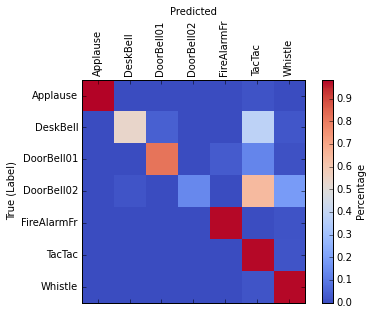

             precision    recall  f1-score   support

   Applause       1.00      0.98      0.99        64
   DeskBell       0.96      0.54      0.69       124
 DoorBell01       0.92      0.82      0.87        84
 DoorBell02       1.00      0.14      0.25       142
FireAlarmFr       0.98      0.98      0.98       180
     TacTac       0.25      0.98      0.39        51
    Whistle       0.55      0.98      0.70        44

avg / total       0.89      0.71      0.70       689



In [13]:
import warnings
warnings.filterwarnings('ignore')
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.0)
predicted_class = [x.class_predicted for x in predicted]
print_report(expected, predicted_class, labels)

warnings.filterwarnings('default')

## 1) Confusion score using threshold
We use the same predicted values.. but this time we filter the values based on threshold of prediction confidence
we are going to use threshold: 0.1, 0.2, 0.3, ..., 0.8, 0.9, threshold 

In [22]:
pylab.plot([x.confidence for x in predicted])
pylab.show()

In [120]:
for threshold in np.arange(0.10, 1.00, 0.10):
    print("THRESHOLD %s" % threshold)
    prediction_df = pd.DataFrame([[x.confidence, x.class_predicted, expected_val] for x, expected_val in zip(predicted, expected)], columns=['confidence', 'class_predicted', 'expected'])
    mask_array = prediction_df.confidence > threshold
    predicted_class = list(prediction_df.class_predicted[mask_array])
    expected_class = list(prediction_df.expected[mask_array])
    print_report(expected_class, predicted_class, labels)

### Conclusion
Ce qu'on voit c'est que ça n'est vraiment pas super.. notamment pour la classe DoorBell02 .. qui semble avoir des taux assez élevé de confiance alors qu'on detecte un tactac..

Mais il faut faire attention le "support" est tres tres faible, ca signifie que toute les detection doorbell2 sont en dessous du seuil, donc il y a de tres grande chance qu'un seuil dynamique par classe fonctionne très très bien: à essayer.


Donc utilise un seuil generique pour tous ça ne semble pas bon..
Remarquons de plus 

## Filtering by filename (ONLY FOR OFFLINE)
Another idea is to compute an unique class per wav file.. based on the maximum confidence score. Warning this method is not usefull for online processing

In [25]:
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.0)
prediction_df = pd.DataFrame([[x.confidence, x.class_predicted, x.timestamp_start, expected_val, filename] for x, expected_val, filename in zip(predicted, expected, filenames)], columns=['confidence', 'class_predicted', 'timestamp_start', 'expected', 'filename'])
prediction_df.head()

In [26]:
# we keep only value with maximum confidence thx to stackoverflow : http://stackoverflow.com/questions/19818756/extract-row-with-maximum-value-in-a-group-pandas-dataframe
prediction_with_only_max = prediction_df.iloc[prediction_df.groupby(['filename']).apply(lambda x: x['confidence'].idxmax())]  # we filter by filename with foldname included
print_report(list(prediction_with_only_max.expected), list(prediction_with_only_max.class_predicted), labels)

### where is the maximum? 
one question is where is the maximum ? is it always at the begining of file ?

In [1]:
prediction_with_only_m
ax.timestamp_start.hist(bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

So clearly the maximum seems to be at the first 1 seconds 

## Calibration of probability per class

First we need to visualize the distribution of confidence for well classified and for wrong classified for each class.

#### we use data with all values.. as in online..

In [17]:
import warnings
warnings.filterwarnings('ignore')
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.0)
prediction_df = pd.DataFrame([[x.confidence, x.class_predicted, x.timestamp_start, expected_val, filename] for x, expected_val, filename in zip(predicted, expected, filenames)], columns=['confidence', 'class_predicted', 'timestamp_start', 'expected', 'filename'])

warnings.filterwarnings('default')


 - first distribution of confidence for all data
     


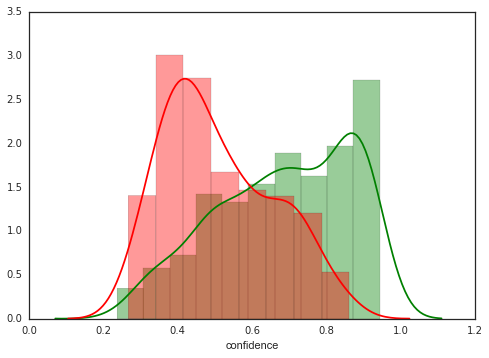

In [18]:
#%pylab qt
mask_well_classified = prediction_df.expected == prediction_df.class_predicted
mask_wrong_classified = ~mask_well_classified
import seaborn as sns
sns.set(style="white", palette="muted")
sns.distplot(prediction_df.confidence[mask_well_classified], color='g')
sns.distplot(prediction_df.confidence[~mask_well_classified], color='r')
pylab.show()

# now looking by class 


Populating the interactive namespace from numpy and matplotlib
group_name Applause
1


`%matplotlib` prevents importing * from pylab and numpy


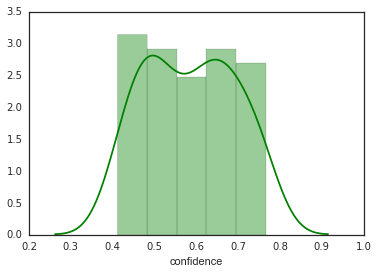


group_name DeskBell


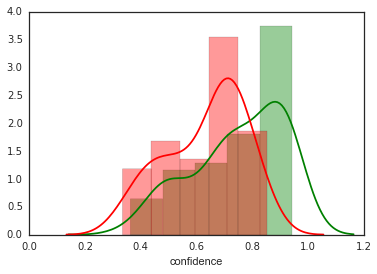


group_name DoorBell01


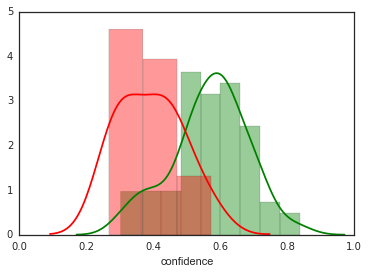


group_name DoorBell02


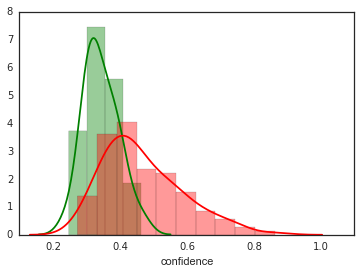


group_name FireAlarmFr


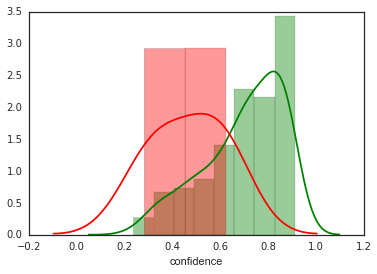


group_name TacTac
1


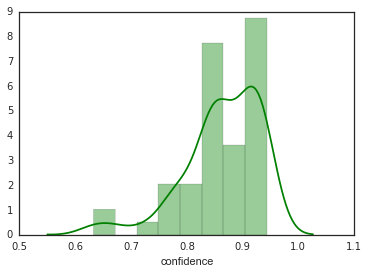


group_name Whistle
1


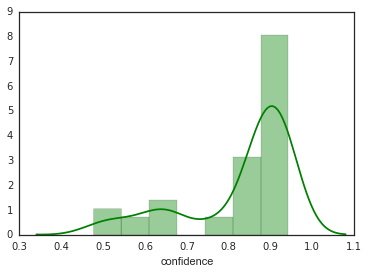

In [32]:
%pylab inline
for group_name, g in prediction_df.groupby('expected'):
    print("group_name %s" % group_name)
    sns.distplot(g.confidence[mask_well_classified], color='g')
    v = g.confidence[~mask_well_classified]
    try:
        sns.distplot(v, color='r')
    except Exception as e:
        print(len(v))
    pylab.show()
    pylab.figure()
    print("")

Et si on plottait les reliability curve... ca ca peut être interessant


In [47]:
# computing fraction of positive
def compute_fraction_of_positive(expected, predicted, confidence, threshold=0.5):
    mask = confidence < threshold
    num_positive = np.sum(expected[mask] == predicted[mask])
    fraction_of_positive = num_positive / float(len(expected))
    return fraction_of_positive

In [54]:
import warnings
warnings.filterwarnings('ignore')
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=1.)
prediction_df = pd.DataFrame([[x.confidence, x.class_predicted, x.timestamp_start, expected_val, filename] for x, expected_val, filename in zip(predicted, expected, filenames)], columns=['confidence', 'class_predicted', 'timestamp_start', 'expected', 'filename'])
warnings.filterwarnings('default')

In [61]:
fraction_of_positive_global = [compute_fraction_of_positive(prediction_df.expected, prediction_df.class_predicted, prediction_df.confidence, threshold) for threshold in arange(0, 1.1, 0.1)]

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(arange(0, 1.1, 0.1), fraction_of_positive_global)
pylab.suptitle("Global reliability curve")
sns.distplot(prediction_df.confidence, color='b')

Applause
DeskBell
DoorBell01
DoorBell02
FireAlarmFr
TacTac
Whistle


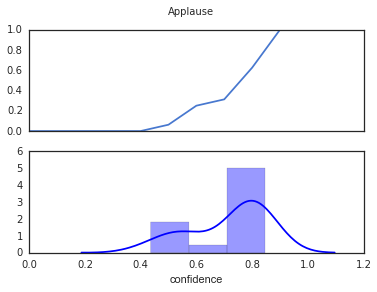

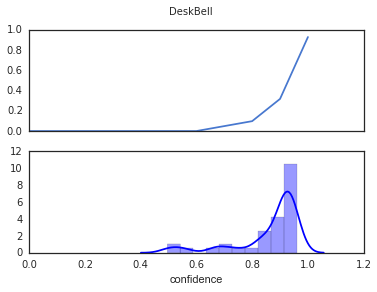

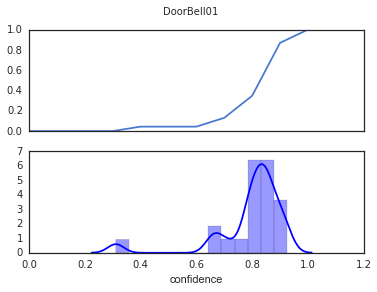

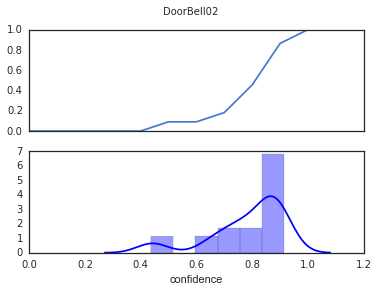

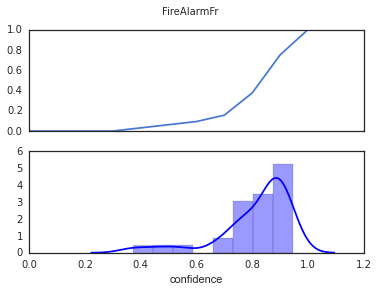

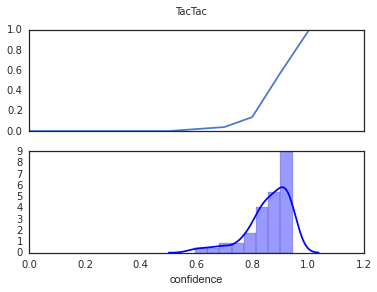

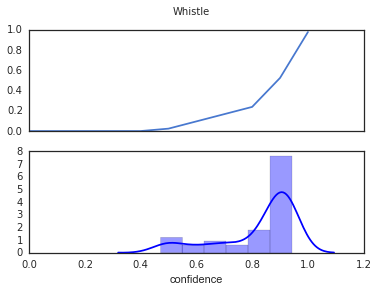

In [68]:
# now if we do per class

for classname, g in prediction_df.groupby('expected'):
    
    fraction_of_positive_global = [compute_fraction_of_positive(g.expected, g.class_predicted, g.confidence, threshold) for threshold in arange(0, 1.1, 0.1)]
    print(classname)
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(arange(0, 1.1, 0.1), fraction_of_positive_global)
    pylab.suptitle(classname)
    sns.distplot(g.confidence, color='b')

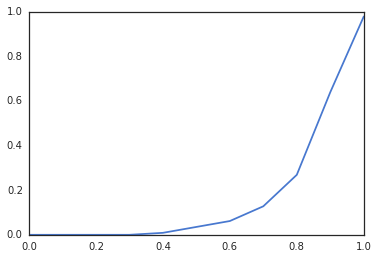

In [52]:
# dans le cas ou on prend tout le signal..  pas de window block
import warnings
warnings.filterwarnings('ignore')
expected, predicted, labels, filenames = get_expected_predicted_stratified_fold(stratified_fold, df, window_block=None)
prediction_df = pd.DataFrame([[x.confidence, x.class_predicted, x.timestamp_start, expected_val, filename] for x, expected_val, filename in zip(predicted, expected, filenames)], columns=['confidence', 'class_predicted', 'timestamp_start', 'expected', 'filename'])
warnings.filterwarnings('default')

fraction_of_positive_global = [compute_fraction_of_positive(prediction_df.expected, prediction_df.class_predicted, prediction_df.confidence, threshold) for threshold in arange(0, 1.1, 0.1)]
pylab.plot(arange(0, 1.1, 0.1), fraction_of_positive_global)